## Sampling Method Comparison

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy

%matplotlib inline

/opt/conda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### 1. Data

#### 1.1. Load Data

In [2]:
housing = pd.read_csv('housing.csv')

In [3]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


#### 1.2. Review Data

/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


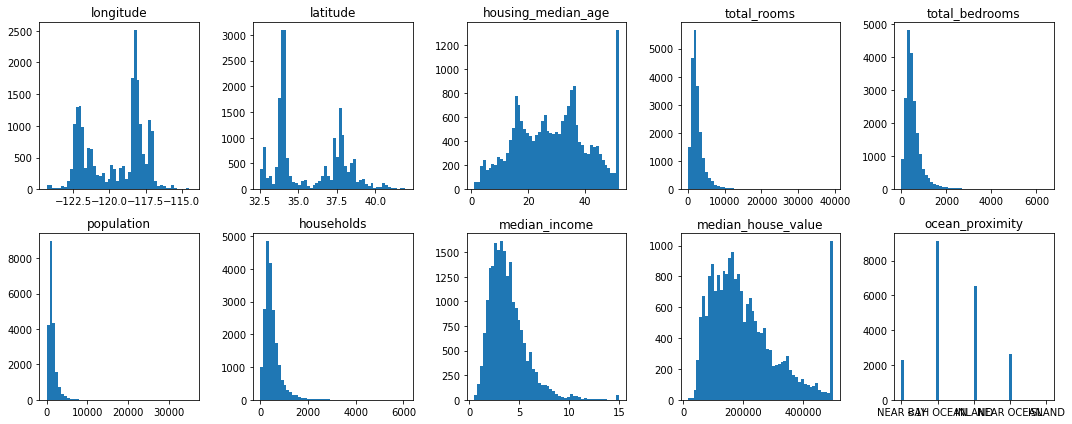

In [4]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(15,6))
ax = axes.ravel()

for i, axi in enumerate(ax):
    axi.hist(housing[housing.columns[i]], bins=50)
    axi.set_title(housing.columns[i])

fig.tight_layout()

In [5]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

#### 1.3. Reduce Data

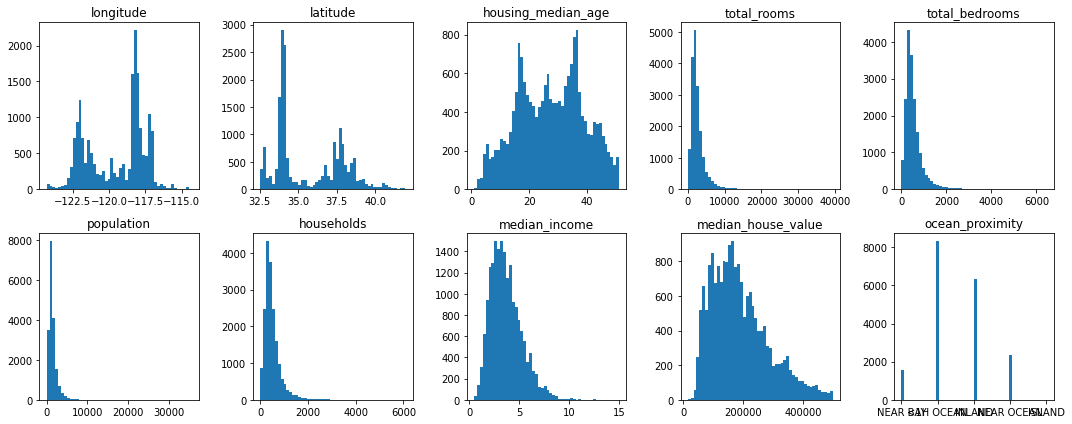

In [6]:
housing_r = housing.copy()
housing_r = housing_r[housing_r["housing_median_age"] < housing_r["housing_median_age"].max()]
housing_r = housing_r[housing_r["median_house_value"] < housing_r["median_house_value"].max()]

fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(15,6))
ax = axes.ravel()

for i, axi in enumerate(ax):
    axi.hist(housing_r[housing_r.columns[i]], bins=50)
    axi.set_title(housing_r.columns[i])

fig.tight_layout()

In [7]:
housing_r['ocean_proximity'].value_counts()

<1H OCEAN     8331
INLAND        6344
NEAR OCEAN    2328
NEAR BAY      1567
ISLAND           2
Name: ocean_proximity, dtype: int64

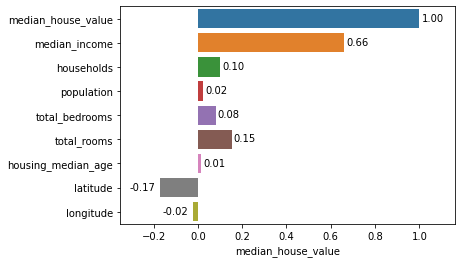

In [8]:
columns = list(housing_r)
columns.reverse()

cor = housing_r[columns].corr()

fig, ax = plt.subplots()
sns.barplot(cor['median_house_value'], cor.index, ax=ax)

xlim_min = np.inf
xlim_max = -np.inf
for patch in ax.patches:
    if patch.get_width() >= 0:
        text_x = patch.get_width()+0.06
    else:
        text_x = patch.get_width()-0.08
        
    if text_x > xlim_max:
        xlim_max = text_x
    if text_x < xlim_min:
        xlim_min = text_x
    text_y = patch.get_y()+0.5
    text = f'{patch.get_width():0.2f}'
    ax.text(text_x, text_y, text, ha='center')
ax.set_xlim(xlim_min-0.1, xlim_max+0.1)
plt.show()

### 2. Sampling

#### 2.1. Data Quantization: 'median_income'

In [9]:
housing_r['income_cat'] = pd.cut(
    housing_r['median_income'], bins=[0, 2, 4, 6, 8, np.inf], labels=[1, 2, 3, 4, 5]
)

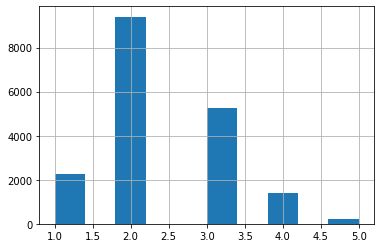

In [10]:
housing_r['income_cat'].hist();

#### 2.1. Random Sampling

In [11]:
from sklearn.model_selection import train_test_split

train_random, test_random = train_test_split(housing_r, test_size=0.3, random_state=42)

#### 2.2. Stratified Sampling : 'median_income', 'ocean_proximity'

In [12]:
train_strat, test_strat = train_test_split(housing_r, test_size=0.3, random_state=42, stratify=housing_r['income_cat'])

#### 2.3. Sampling Comparison

In [13]:
def income_cat_proportions(housing_r):
    return housing_r["income_cat"].value_counts() / len(housing_r)


compare_props = pd.DataFrame(
    {
        "Random": test_random["income_cat"].value_counts(),
        "Stratified": test_strat["income_cat"].value_counts(),
        "Overall (%)": income_cat_proportions(housing_r) * 100,
        "Random (%)": income_cat_proportions(test_random) * 100,
        "Stratified (%)": income_cat_proportions(test_strat) * 100,
    }
).sort_index()

compare_props["Random %err"] = (
    100 * compare_props["Random (%)"] / compare_props["Overall (%)"] - 100
)
compare_props["Stratified %err"] = (
    100 * compare_props["Stratified (%)"] / compare_props["Overall (%)"] - 100
)

compare_props

,Random,Stratified,Overall (%),Random (%),Stratified (%),Random %err,Stratified %err
1,698,675,12.115012,12.526920,12.114142,3.399984,-0.007179
2,2817,2821,50.629981,50.556353,50.628141,-0.145423,-0.003634
3,1556,1583,28.419126,27.925341,28.409907,-1.737508,-0.032439
4,435,423,7.586690,7.806892,7.591529,2.902478,0.063788
5,66,70,1.249192,1.184494,1.256281,-5.179221,0.567493


#### 2.4. Data Restoration : 'median_income'

In [14]:
train_random = train_random.drop("income_cat", axis=1)
test_random = test_random.drop("income_cat", axis=1)
train_strat = train_strat.drop("income_cat", axis=1)
test_strat = test_strat.drop("income_cat", axis=1)
housing_r = housing_r.drop("income_cat", axis=1)

### 3. Pipeline

#### 3.1. pipeline preparation

In [15]:
housing_r.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18572 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           18572 non-null  float64
 1   latitude            18572 non-null  float64
 2   housing_median_age  18572 non-null  float64
 3   total_rooms         18572 non-null  float64
 4   total_bedrooms      18379 non-null  float64
 5   population          18572 non-null  float64
 6   households          18572 non-null  float64
 7   median_income       18572 non-null  float64
 8   median_house_value  18572 non-null  float64
 9   ocean_proximity     18572 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [16]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

ycol = ['median_house_value']
catcols = ['ocean_proximity']
numcols = list(set(housing_r.columns) - set(catcols) - set(ycol))
print(f'# numericical columns: {numcols}')
print(f'# categorical columns: {catcols}')

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room

    def fit(self, X, y=None):
        return self

    def transform(self, X):  # feature addition
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[
                X, rooms_per_household, population_per_household, bedrooms_per_room
            ]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

num_pipeline = Pipeline([("imputer", SimpleImputer(strategy="median")),
                         ("attribs_adder", CombinedAttributesAdder()),
                         ("std_scaler", StandardScaler()),])  
cat_pipeline = Pipeline([("onehotencoder", OneHotEncoder(handle_unknown='ignore', drop=None))])
full_pipeline = ColumnTransformer(
    [("num", num_pipeline, numcols), ("cat", cat_pipeline, catcols)]
)

# numericical columns: ['longitude', 'median_income', 'total_rooms', 'total_bedrooms', 'latitude', 'households', 'population', 'housing_median_age']
# categorical columns: ['ocean_proximity']


#### 3.2. Variables Separation

In [17]:
Y_train_random = train_random['median_house_value']
X_train_random = train_random.drop('median_house_value', axis=1)

Y_train_strat = train_strat['median_house_value']
X_train_strat = train_strat.drop('median_house_value', axis=1)

In [18]:
Y_test_random = test_random['median_house_value']
X_test_random = test_random.drop('median_house_value', axis=1)

Y_test_strat = test_strat['median_house_value']
X_test_strat = test_strat.drop('median_house_value', axis=1)

### 4. Machine Learning (overall)

In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

#### 4.1. preprocessing through pipeline

In [20]:
pipeline_random = deepcopy(full_pipeline)
X_train_random_pre = pipeline_random.fit_transform(X_train_random)

pipeline_strat = deepcopy(full_pipeline)
X_train_strat_pre = pipeline_strat.fit_transform(X_train_strat)

#### 4.2. Random Sampling

In [21]:
rf_random = RandomForestRegressor(n_estimators=30, max_features=8, random_state=42)
rf_random.fit(X_train_random_pre, Y_train_random)

X_test_random_pre = pipeline_random.transform(X_test_random)
Y_pred_random = rf_random.predict(X_test_random_pre)
rmse_random = np.sqrt(mean_squared_error(Y_pred_random, Y_test_random))
print(rmse_random)

45294.38597205418


#### 4.3. Stratified Sampling (overall)

In [22]:
rf_strat = RandomForestRegressor(n_estimators=30, max_features=8, random_state=42)
rf_strat.fit(X_train_strat_pre, Y_train_strat)

X_test_strat_pre = pipeline_strat.transform(X_test_strat)
Y_pred_strat = rf_strat.predict(X_test_strat_pre)
rmse_strat = np.sqrt(mean_squared_error(Y_pred_strat, Y_test_strat))
print(rmse_strat)

44476.77416350058


#### 4.4. Visualization (overall)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


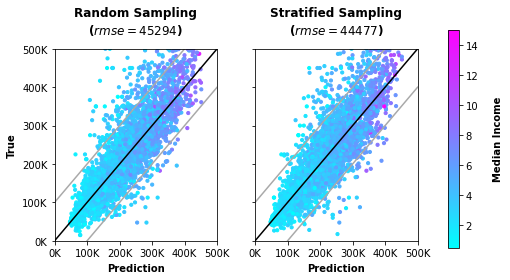

In [23]:
fig, ax = plt.subplots(ncols=2, figsize=(8,4), sharex=True, sharey=True)

ax[0].scatter(Y_pred_random, Y_test_random, c=X_test_random['median_income'], cmap='cool', s=10)
im = ax[1].scatter(Y_pred_strat, Y_test_strat, c=X_test_strat['median_income'], cmap='cool', s=10)

ax[0].plot([0,500000], [0,500000], c='k')
ax[1].plot([0,500000], [0,500000], c='k')
ax[0].plot([100000,500000], [0,400000], c='darkgray')
ax[0].plot([0,400000], [100000,500000], c='darkgray')
ax[1].plot([100000,500000], [0,400000], c='darkgray')
ax[1].plot([0,400000], [100000,500000], c='darkgray')

ax[0].set_xlim(0, 500000)
ax[0].set_ylim(0, 500000)

ax[0].set_xlabel('Prediction', fontweight='bold', labelpad=5)
ax[1].set_xlabel('Prediction', fontweight='bold', labelpad=5)
ax[0].set_ylabel('True', fontweight='bold', labelpad=5)

ticks = ax[0].get_xticks()
ticks_K = [f'{tick/1000:0.0f}K' for tick in ticks]
ax[0].set_xticklabels(ticks_K)
ax[0].set_yticklabels(ticks_K)
ax[1].set_xticklabels(ticks_K)

ax[0].set_title(f'Random Sampling\n($rmse={rmse_random:0.0f}$)', fontweight='bold', pad=15)
ax[1].set_title(f'Stratified Sampling\n($rmse={rmse_strat:0.0f}$)', fontweight='bold', pad=15)

cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Median Income', fontweight='bold', labelpad=15)
fig.tight_layout(rect=(0,0,0.75,1))
fig.savefig('13_comp.png')
plt.show()

In [24]:
diff = (rmse_strat/rmse_random - 1) * 100
print(f"RMSE difference is {diff:0.3f} %, relatively.")

RMSE difference is -1.805 %, relatively.


### 5. Machine Learning (rich: high median income)

#### 5.1. Data Selection (median income > 8)

In [25]:
test_random_rich = test_random.loc[test_random['median_income'] > 8]
test_strat_rich = test_strat.loc[test_strat['median_income'] > 8]

In [26]:
Y_test_random_rich = test_random_rich['median_house_value']
X_test_random_rich = test_random_rich.drop('median_house_value', axis=1)

Y_test_strat_rich = test_strat_rich['median_house_value']
X_test_strat_rich = test_strat_rich.drop('median_house_value', axis=1)

#### 5.2. Random Sampling

In [27]:
X_test_random_rich_pre = pipeline_random.transform(X_test_random_rich)
Y_pred_random_rich = rf_random.predict(X_test_random_rich_pre)
rmse_random_rich = np.sqrt(mean_squared_error(Y_pred_random_rich, Y_test_random_rich))
print(rmse_random_rich)

55437.28025362709


#### 5.3. Stratified Sampling

In [28]:
X_test_strat_rich_pre = pipeline_strat.transform(X_test_strat_rich)
Y_pred_strat_rich = rf_strat.predict(X_test_strat_rich_pre)
rmse_strat_rich = np.sqrt(mean_squared_error(Y_pred_strat_rich, Y_test_strat_rich))
print(rmse_strat_rich)

54658.86340648594


#### 5.4. Visualization

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


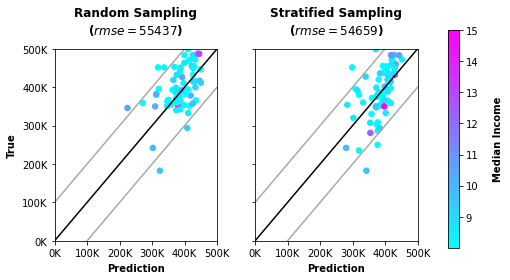

In [29]:
fig, ax = plt.subplots(ncols=2, figsize=(8,4), sharex=True, sharey=True)

ax[0].scatter(Y_pred_random_rich, Y_test_random_rich, c=X_test_random_rich['median_income'], cmap='cool', s=30)
im = ax[1].scatter(Y_pred_strat_rich, Y_test_strat_rich, c=X_test_strat_rich['median_income'], cmap='cool', s=30)

ax[0].plot([0,500000], [0,500000], c='k')
ax[1].plot([0,500000], [0,500000], c='k')
ax[0].plot([100000,500000], [0,400000], c='darkgray')
ax[0].plot([0,400000], [100000,500000], c='darkgray')
ax[1].plot([100000,500000], [0,400000], c='darkgray')
ax[1].plot([0,400000], [100000,500000], c='darkgray')

ax[0].set_xlim(0, 500000)
ax[0].set_ylim(0, 500000)

ax[0].set_xlabel('Prediction', fontweight='bold', labelpad=5)
ax[1].set_xlabel('Prediction', fontweight='bold', labelpad=5)
ax[0].set_ylabel('True', fontweight='bold', labelpad=5)

ticks = ax[0].get_xticks()
ticks_K = [f'{tick/1000:0.0f}K' for tick in ticks]
ax[0].set_xticklabels(ticks_K)
ax[0].set_yticklabels(ticks_K)
ax[1].set_xticklabels(ticks_K)

ax[0].set_title(f'Random Sampling\n($rmse={rmse_random_rich:0.0f}$)', fontweight='bold', pad=15)
ax[1].set_title(f'Stratified Sampling\n($rmse={rmse_strat_rich:0.0f}$)', fontweight='bold', pad=15)

cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Median Income', fontweight='bold', labelpad=15)
fig.tight_layout(rect=(0,0,0.75,1))
fig.savefig('13_comp_rich.png')
plt.show()

In [30]:
diff = (rmse_strat_rich/rmse_random_rich - 1) * 100
print(f"RMSE difference is {diff:0.3f} %, relatively.")

RMSE difference is -1.404 %, relatively.


### 6. Statistic Inspection

In [31]:
from functools import reduce

def run_(housing_r, sfeats, rmses_random, rmses_strat, rmses_random_rich, rmses_strat_rich, random_state_split):
    
    housing_r['income_cat'] = pd.cut(housing_r['median_income'], bins=[0, 2, 4, 6, 8, np.inf], labels=[1, 2, 3, 4, 5])
    train_random, test_random = train_test_split(housing_r, test_size=0.3, random_state=random_state_split)
    train_strat, test_strat = train_test_split(housing_r, test_size=0.3, random_state=random_state_split, stratify=housing_r[sfeats])
    
    train_random = train_random.drop("income_cat", axis=1)
    test_random = test_random.drop("income_cat", axis=1)
    train_strat = train_strat.drop("income_cat", axis=1)
    test_strat = test_strat.drop("income_cat", axis=1)
    housing_r = housing_r.drop("income_cat", axis=1)
    
    Y_train_random = train_random['median_house_value']
    X_train_random = train_random.drop('median_house_value', axis=1)

    Y_train_strat = train_strat['median_house_value']
    X_train_strat = train_strat.drop('median_house_value', axis=1)
    
    Y_test_random = test_random['median_house_value']
    X_test_random = test_random.drop('median_house_value', axis=1)

    Y_test_strat = test_strat['median_house_value']
    X_test_strat = test_strat.drop('median_house_value', axis=1)
    
    pipeline_random = deepcopy(full_pipeline)
    X_train_random_pre = pipeline_random.fit_transform(X_train_random)

    pipeline_strat = deepcopy(full_pipeline)
    X_train_strat_pre = pipeline_strat.fit_transform(X_train_strat)
    
    rf_random = RandomForestRegressor(n_estimators=30, max_features=8, random_state=42)
    rf_random.fit(X_train_random_pre, Y_train_random)

    X_test_random_pre = pipeline_random.transform(X_test_random)
    Y_pred_random = rf_random.predict(X_test_random_pre)
    rmse_random = np.sqrt(mean_squared_error(Y_pred_random, Y_test_random))
    rmses_random.append(rmse_random)
    
    rf_strat = RandomForestRegressor(n_estimators=30, max_features=8, random_state=42)
    rf_strat.fit(X_train_strat_pre, Y_train_strat)

    X_test_strat_pre = pipeline_strat.transform(X_test_strat)
    Y_pred_strat = rf_strat.predict(X_test_strat_pre)
    rmse_strat = np.sqrt(mean_squared_error(Y_pred_strat, Y_test_strat))
    rmses_strat.append(rmse_strat)

    # rich
    test_random_rich = test_random.loc[test_random['median_income'] > 8]
    test_strat_rich = test_strat.loc[test_strat['median_income'] > 8]
    
    Y_test_random_rich = test_random_rich['median_house_value']
    X_test_random_rich = test_random_rich.drop('median_house_value', axis=1)

    Y_test_strat_rich = test_strat_rich['median_house_value']
    X_test_strat_rich = test_strat_rich.drop('median_house_value', axis=1)
    
    X_test_random_rich_pre = pipeline_random.transform(X_test_random_rich)
    Y_pred_random_rich = rf_random.predict(X_test_random_rich_pre)
    rmse_random_rich = np.sqrt(mean_squared_error(Y_pred_random_rich, Y_test_random_rich))
    rmses_random_rich.append(rmse_random_rich)
    
    X_test_strat_rich_pre = pipeline_strat.transform(X_test_strat_rich)
    Y_pred_strat_rich = rf_strat.predict(X_test_strat_rich_pre)
    rmse_strat_rich = np.sqrt(mean_squared_error(Y_pred_strat_rich, Y_test_strat_rich))
    rmses_strat_rich.append(rmse_strat_rich)

    return rmses_random, rmses_strat, rmses_random_rich, rmses_strat_rich
    

def run(housing_r, sfeats):    
    rmses_random = []
    rmses_strat = []
    rmses_random_rich = []
    rmses_strat_rich = []

    for random_state_split in range(0, 1000, 10):
        random, strat, random_rich, strat_rich = run_(housing_r, sfeats, rmses_random, rmses_strat, rmses_random_rich, rmses_strat_rich, random_state_split)
        
    df_run = pd.DataFrame({'random': rmses_random, 
                           'strat': rmses_strat, 
                           'random_rich': rmses_random_rich, 
                           'strat_rich': rmses_strat_rich}) 
    
    filename = '100run_' + reduce(lambda x, y:x+'_'+y, sfeats) + '.csv'
    df_run.to_csv(filename)

    return df_run


#### 6.1. Run Over Variables

* 'median_income'

In [32]:
df_run1 = run(housing_r, ['income_cat'])

* 'median_income' and 'ocean_proximity'

In [33]:
df_run2 = run(housing_r, ['income_cat', 'ocean_proximity'])

##### 6.1.1. Review: Overall Data

* 'median_income'

In [34]:
df_run1.mean(axis=0)

random         45099.430144
strat          45006.298559
random_rich    56796.149704
strat_rich     57350.906593
dtype: float64

In [35]:
df_run1.std(axis=0)

random          656.515669
strat           748.704881
random_rich    5575.163795
strat_rich     4837.299688
dtype: float64

In [36]:
len(np.where(df_run1['random'] > df_run1['strat'])[0])

53

* 'median_income' and 'ocean_proximity'

In [37]:
df_run2.mean(axis=0)

random         45099.430144
strat          45160.820150
random_rich    56796.149704
strat_rich     57327.688725
dtype: float64

In [38]:
df_run2.std(axis=0)

random          656.515669
strat           646.464780
random_rich    5575.163795
strat_rich     4841.410970
dtype: float64

In [39]:
len(np.where(df_run2['random'] > df_run2['strat'])[0])

51

##### 6.1.2. Review: 'Rich' Data

* 'median_income'

In [40]:
df_run1.mean(axis=0)

random         45099.430144
strat          45006.298559
random_rich    56796.149704
strat_rich     57350.906593
dtype: float64

In [41]:
df_run1.std(axis=0)

random          656.515669
strat           748.704881
random_rich    5575.163795
strat_rich     4837.299688
dtype: float64

In [42]:
len(np.where(df_run1['random_rich'] > df_run1['strat_rich'])[0])

49

* 'median_income' and 'ocean_proximity'

In [43]:
df_run2.mean(axis=0)

random         45099.430144
strat          45160.820150
random_rich    56796.149704
strat_rich     57327.688725
dtype: float64

In [44]:
df_run2.std(axis=0)

random          656.515669
strat           646.464780
random_rich    5575.163795
strat_rich     4841.410970
dtype: float64

In [45]:
len(np.where(df_run2['random_rich'] > df_run2['strat_rich'])[0])

47

##### 6.1.3. Statistical Test: Overall Data

* 'median_income'

In [46]:
import scipy.stats as stats

# Variance Test
bartlett1 = stats.bartlett(df_run1['random'], df_run1['strat'])
fligner1 = stats.fligner(df_run1['random'], df_run1['strat'])
levene1 = stats.levene(df_run1['random'], df_run1['strat'])

# T-Test
ttest1 = stats.ttest_ind(df_run1['random'], df_run1['strat'], equal_var=True)

In [47]:
columns = pd.MultiIndex.from_tuples([('Equal Variance Test', 'Bartlett'),
                                     ('Equal Variance Test', 'Fligner'),
                                     ('Equal Variance Test', 'Levene'),
                                     ('T-Test', 'Independent')])
indices = pd.MultiIndex.from_tuples([('median_income', 'overall')])
df_stat = pd.DataFrame(data = [[list(bartlett1)[1], list(fligner1)[1], list(levene1)[1], list(ttest1)[1]]], 
                       columns = columns, index=indices)
df_stat

Equal Variance Test                          T-Test
                                 Bartlett   Fligner    Levene Independent
median_income overall            0.192835  0.237748  0.249987    0.350791

* 'median_income' and 'ocean_proximity'

In [48]:
# Variance Test

bartlett2 = stats.bartlett(df_run2['random'], df_run2['strat'])
fligner2 = stats.fligner(df_run2['random'], df_run2['strat'])
levene2 = stats.levene(df_run2['random'], df_run2['strat'])

# T-Test

ttest2 = stats.ttest_ind(df_run2['random'], df_run2['strat'], equal_var=True)

In [49]:
indices = pd.MultiIndex.from_tuples([('median_income & ocean_proximity', 'overall')])
df_stat_tmp = pd.DataFrame(data = [[list(bartlett2)[1], list(fligner2)[1], list(levene2)[1], list(ttest2)[1]]], 
                       columns = columns, index=indices)

df_stat = pd.concat([df_stat, df_stat_tmp])

##### 6.1.4. Statistical Test: 'Rich' Data

* 'median_income'

In [50]:
# Variance Test

bartlett1_rich = stats.bartlett(df_run1['random_rich'], df_run1['strat_rich'])
fligner1_rich = stats.fligner(df_run1['random_rich'], df_run1['strat_rich'])
levene1_rich = stats.levene(df_run1['random_rich'], df_run1['strat_rich'])

# T-Test

ttest1_rich = stats.ttest_ind(df_run1['random_rich'], df_run1['strat_rich'], equal_var=True)

In [51]:
indices = pd.MultiIndex.from_tuples([('median_income', 'rich')])
df_stat_tmp = pd.DataFrame(data = [[list(bartlett1_rich)[1], list(fligner1_rich)[1], list(levene1_rich)[1], list(ttest1_rich)[1]]], 
                       columns = columns, index=indices)

df_stat = pd.concat([df_stat, df_stat_tmp])

* 'median_income' and 'ocean_proximity'

In [52]:
# Variance Test

bartlett2_rich = stats.bartlett(df_run2['random_rich'], df_run2['strat_rich'])
fligner2_rich = stats.fligner(df_run2['random_rich'], df_run2['strat_rich'])
levene2_rich = stats.levene(df_run2['random_rich'], df_run2['strat_rich'])

# T-Test

ttest2_rich = stats.ttest_ind(df_run2['random_rich'], df_run2['strat_rich'], equal_var=True)

In [53]:
indices = pd.MultiIndex.from_tuples([('median_income & ocean_proximity', 'rich')])
df_stat_tmp = pd.DataFrame(data = [[list(bartlett2_rich)[1], list(fligner2_rich)[1], list(levene2_rich)[1], list(ttest2_rich)[1]]], 
                       columns = columns, index=indices)

df_stat = pd.concat([df_stat, df_stat_tmp])

In [54]:
print('# P-values of Equal-Variance Tests and T-Test')
df_stat.sort_index()

# P-values of Equal-Variance Tests and T-Test


Equal Variance Test            \
                                                   Bartlett   Fligner   
median_income                   overall            0.192835  0.237748   
                                rich               0.159539  0.104461   
median_income & ocean_proximity overall            0.878307  0.879555   
                                rich               0.162042  0.077690   

                                                       T-Test  
                                           Levene Independent  
median_income                   overall  0.249987    0.350791  
                                rich     0.086943    0.453195  
median_income & ocean_proximity overall  0.878003    0.506003  
                                rich     0.075295    0.472458

#### 6.2. Visualization

In [55]:
sns.set_style('whitegrid')
sns.set_context('talk')

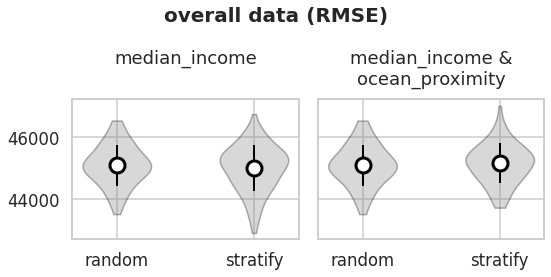

In [56]:
dfs = [df_run1, df_run2]
xlabels = ['random', 'stratify'] #, 'random\n(rich)', 'stratify\n(rich)']
titles = ['median_income', 'median_income &\nocean_proximity']

fig, axes = plt.subplots(ncols=2, figsize=(8, 4), sharey=True)

for df, ax, title in zip(dfs, axes, titles):
    positions = [1,2]
    parts = ax.violinplot([df['random'], df['strat']], showextrema=False, positions=positions)
    for i, pc in enumerate(parts['bodies']):
        color='gray'
        pc.set_facecolor(color)
        pc.set_edgecolor('k')

    ax.errorbar(x=np.arange(1, 5)[:2], y=df.mean(axis=0).iloc[:2], yerr = df.std(axis=0).iloc[:2], 
                fmt='o', mec='k', mew=3, mfc='w', ms=15, lw=2, c='k'
               )
    ax.set_xticks(positions)
    ax.set_xticklabels(xlabels)
    ax.set_title(title, fontdict={'verticalalignment':'top'}, pad=50)
    
fig.suptitle('overall data (RMSE)', fontsize=20, fontweight='bold')
fig.tight_layout(rect=[0, 0, 1, 0.9])
fig.savefig('comp_all.png')

In [57]:
df_run1['random_mean_mv'] = 0
df_run1['strat_mean_mv'] = 0
df_run1['random_std_mv'] = 0
df_run1['strat_std_mv'] = 0
df_run2['random_mean_mv'] = 0
df_run2['strat_mean_mv'] = 0
df_run2['random_std_mv'] = 0
df_run2['strat_std_mv'] = 0


for i in range(100):
    df_run1['random_mean_mv'].loc[i] = df_run1['random'].iloc[:i].mean()
    df_run1['strat_mean_mv'].loc[i] = df_run1['strat'].iloc[:i].mean()
    df_run1['random_std_mv'].loc[i] = df_run1['random'].iloc[:i].std()
    df_run1['strat_std_mv'].loc[i] = df_run1['strat'].iloc[:i].std()
    
    df_run2['random_mean_mv'].loc[i] = df_run2['random'].iloc[:i].mean()
    df_run2['strat_mean_mv'].loc[i] = df_run2['strat'].iloc[:i].mean()
    df_run2['random_std_mv'].loc[i] = df_run2['random'].iloc[:i].std()
    df_run2['strat_std_mv'].loc[i] = df_run2['strat'].iloc[:i].std()

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


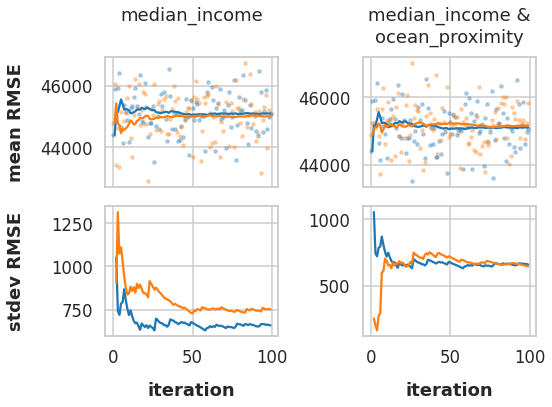

In [58]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8,6), sharex=True)

ax = axes.ravel()

ax[0].scatter(df_run1.index, df_run1['random'], s=10, alpha=0.3)
ax[0].scatter(df_run1.index, df_run1['strat'], s=10, alpha=0.3)
ax[0].plot(df_run1.index, df_run1['random_mean_mv'])
ax[0].plot(df_run1.index, df_run1['strat_mean_mv'])
# ax[0].set_ylim(44000,45000)
ax[0].set_title('median_income', 
                fontdict={'verticalalignment':'top'}, pad=50)
ax[0].set_ylabel('mean RMSE', 
                fontdict={'fontweight':'bold'}, labelpad=15)

ax[1].scatter(df_run2.index, df_run2['random'], s=10, alpha=0.3)
ax[1].scatter(df_run2.index, df_run2['strat'], s=10, alpha=0.3)
ax[1].plot(df_run2.index, df_run2['random_mean_mv'])
ax[1].plot(df_run2.index, df_run2['strat_mean_mv'])
# ax[1].set_ylim(44300,45000)
ax[1].set_title('median_income &\nocean_proximity', 
                fontdict={'verticalalignment':'top'}, pad=50)

ax[2].plot(df_run1.index, df_run1['random_std_mv'])
ax[2].plot(df_run1.index, df_run1['strat_std_mv'])
ax[2].set_ylabel('stdev RMSE', 
                fontdict={'fontweight':'bold'}, labelpad=15)
ax[2].set_xlabel('iteration', fontdict={'fontweight':'bold'}, labelpad=15)

ax[3].plot(df_run2.index, df_run2['random_std_mv'])
ax[3].plot(df_run2.index, df_run2['strat_std_mv'])
ax[3].set_xlabel('iteration', fontdict={'fontweight':'bold'}, labelpad=15)


fig.align_ylabels(ax)
fig.tight_layout()

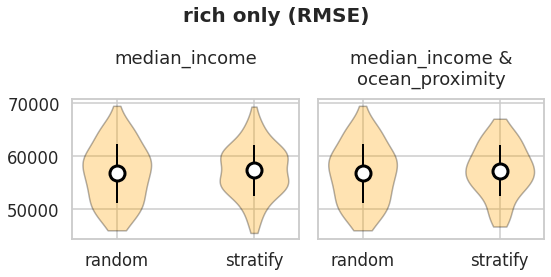

In [59]:
dfs = [df_run1, df_run2]
xlabels = ['random', 'stratify'] #, 'random\n(rich)', 'stratify\n(rich)']
titles = ['median_income', 'median_income &\nocean_proximity']

fig, axes = plt.subplots(ncols=2, figsize=(8, 4), sharey=True)

for df, ax, title in zip(dfs, axes, titles):
    positions = [1,2]
    parts = ax.violinplot([df['random_rich'], df['strat_rich']], showextrema=False, positions=positions)
    for i, pc in enumerate(parts['bodies']):
        color='orange'
        pc.set_facecolor(color)
        pc.set_edgecolor('k')

    ax.errorbar(x=positions, y=df.mean(axis=0).iloc[2:4], yerr = df.std(axis=0).iloc[2:4], 
                fmt='o', mec='k', mew=3, mfc='w', ms=15, lw=2, c='k'
               )
    ax.set_xticks(positions)
    ax.set_xticklabels(xlabels)
    ax.set_title(title, fontdict={'verticalalignment':'top'}, pad=50)
    
fig.suptitle('rich only (RMSE)', fontsize=20, fontweight='bold')
fig.tight_layout(rect=[0, 0, 1, 0.9])
fig.savefig('comp_rich.png')

In [60]:
df_run1['random_rich_mean_mv'] = 0
df_run1['strat_rich_mean_mv'] = 0
df_run1['random_rich_std_mv'] = 0
df_run1['strat_rich_std_mv'] = 0
df_run2['random_rich_mean_mv'] = 0
df_run2['strat_rich_mean_mv'] = 0
df_run2['random_rich_std_mv'] = 0
df_run2['strat_rich_std_mv'] = 0


for i in range(100):
    df_run1['random_rich_mean_mv'].loc[i] = df_run1['random_rich'].iloc[:i].mean()
    df_run1['strat_rich_mean_mv'].loc[i] = df_run1['strat_rich'].iloc[:i].mean()
    df_run1['random_rich_std_mv'].loc[i] = df_run1['random_rich'].iloc[:i].std()
    df_run1['strat_rich_std_mv'].loc[i] = df_run1['strat_rich'].iloc[:i].std()
    
    df_run2['random_rich_mean_mv'].loc[i] = df_run2['random_rich'].iloc[:i].mean()
    df_run2['strat_rich_mean_mv'].loc[i] = df_run2['strat_rich'].iloc[:i].mean()
    df_run2['random_rich_std_mv'].loc[i] = df_run2['random_rich'].iloc[:i].std()
    df_run2['strat_rich_std_mv'].loc[i] = df_run2['strat_rich'].iloc[:i].std()

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


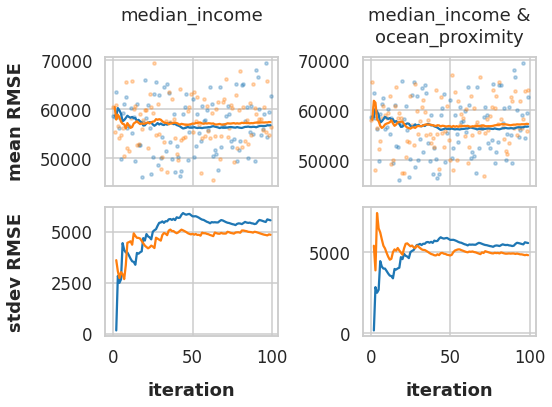

In [61]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8,6), sharex=True)

ax = axes.ravel()

ax[0].scatter(df_run1.index, df_run1['random_rich'], s=10, alpha=0.3)
ax[0].scatter(df_run1.index, df_run1['strat_rich'], s=10, alpha=0.3)
ax[0].plot(df_run1.index, df_run1['random_rich_mean_mv'])
ax[0].plot(df_run1.index, df_run1['strat_rich_mean_mv'])
# ax[0].set_ylim(44000,45000)
ax[0].set_title('median_income', 
                fontdict={'verticalalignment':'top'}, pad=50)
ax[0].set_ylabel('mean RMSE', 
                fontdict={'fontweight':'bold'}, labelpad=15)

ax[1].scatter(df_run2.index, df_run2['random_rich'], s=10, alpha=0.3)
ax[1].scatter(df_run2.index, df_run2['strat_rich'], s=10, alpha=0.3)
ax[1].plot(df_run2.index, df_run2['random_rich_mean_mv'])
ax[1].plot(df_run2.index, df_run2['strat_rich_mean_mv'])
# ax[1].set_ylim(44300,45000)
ax[1].set_title('median_income &\nocean_proximity', 
                fontdict={'verticalalignment':'top'}, pad=50)

ax[2].plot(df_run1.index, df_run1['random_rich_std_mv'])
ax[2].plot(df_run1.index, df_run1['strat_rich_std_mv'])
ax[2].set_ylabel('stdev RMSE', 
                fontdict={'fontweight':'bold'}, labelpad=15)
ax[2].set_xlabel('iteration', fontdict={'fontweight':'bold'}, labelpad=15)


ax[3].plot(df_run2.index, df_run2['random_rich_std_mv'])
ax[3].plot(df_run2.index, df_run2['strat_rich_std_mv'])
ax[3].set_xlabel('iteration', fontdict={'fontweight':'bold'}, labelpad=15)

fig.align_ylabels(ax)
fig.tight_layout()